In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import arff

# Redução de Dimensionalidade
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.1 Carregando dataset

Colab

In [ ]:
file_path = "/content/drive/MyDrive/SI5/electricity-normalized.arff"
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)

Local

In [2]:
file_path = "data/raw/electricity-normalized.arff"
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)

### Converter colunas categóricas de bytes para strings


In [3]:
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode("utf-8")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       45312 non-null  float64
 1   day        45312 non-null  object 
 2   period     45312 non-null  float64
 3   nswprice   45312 non-null  float64
 4   nswdemand  45312 non-null  float64
 5   vicprice   45312 non-null  float64
 6   vicdemand  45312 non-null  float64
 7   transfer   45312 non-null  float64
 8   class      45312 non-null  object 
dtypes: float64(7), object(2)
memory usage: 3.1+ MB


In [5]:
df['class'] = df['class'].apply(lambda val: 1 if val == 'UP' else 0)

In [6]:
df.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526,0.424545
std,0.340308,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373,0.494279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031934,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912,0.000000
50%,0.456329,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912,0.000000
75%,0.880547,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


O Data Set não possi valores nulos

In [7]:
df.isnull().sum()

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64

In [8]:
df

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0
...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,0
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,0
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,0
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,1


## 0.2 Identificando outliers

In [9]:
# Filtra apenas as colunas numéricas
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calcula Q1, Q3 e IQR para cada coluna numérica
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Detecta outliers
outliers = ((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).sum()

In [10]:
outliers

date            0
period          0
nswprice      890
nswdemand      83
vicprice     3683
vicdemand    6052
transfer      420
class           0
dtype: int64

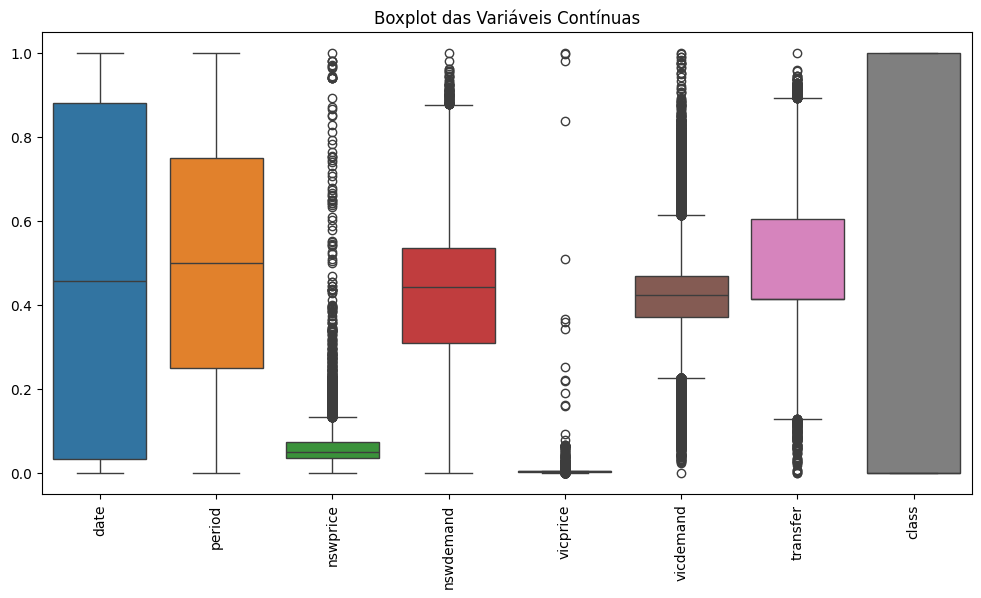

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Boxplot das Variáveis Contínuas")
plt.xticks(rotation=90)
plt.show()

## 0.3 Visualização de dados

In [13]:
categorical_columns = df.select_dtypes(include=[object]).columns
categorical_columns

Index(['day'], dtype='object')

## Descrição da classe alvo

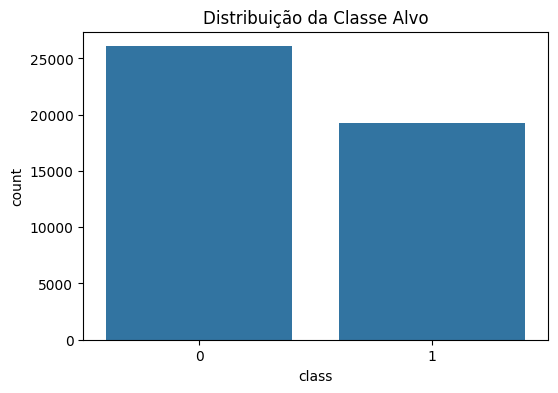

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['class'])
plt.title("Distribuição da Classe Alvo")
plt.show()

## Distribuição das variáveis categóricas


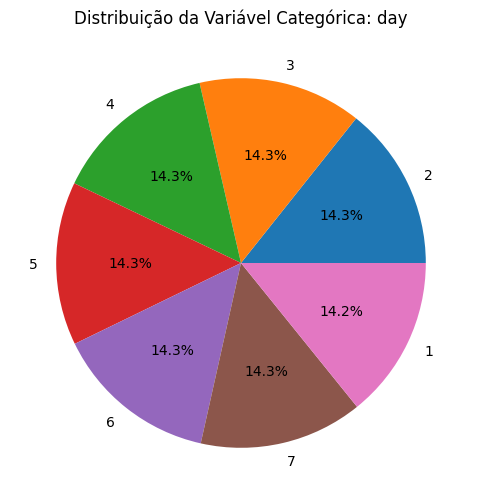

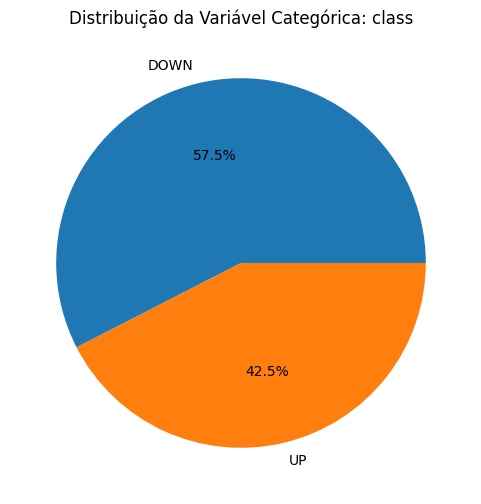

In [16]:
for col in categorical_columns:
    plt.figure(figsize=(6, 6))
    df[col].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f"Distribuição da Variável Categórica: {col}")
    plt.ylabel('')
    plt.show()

## Histogramas para variáveis contínuas


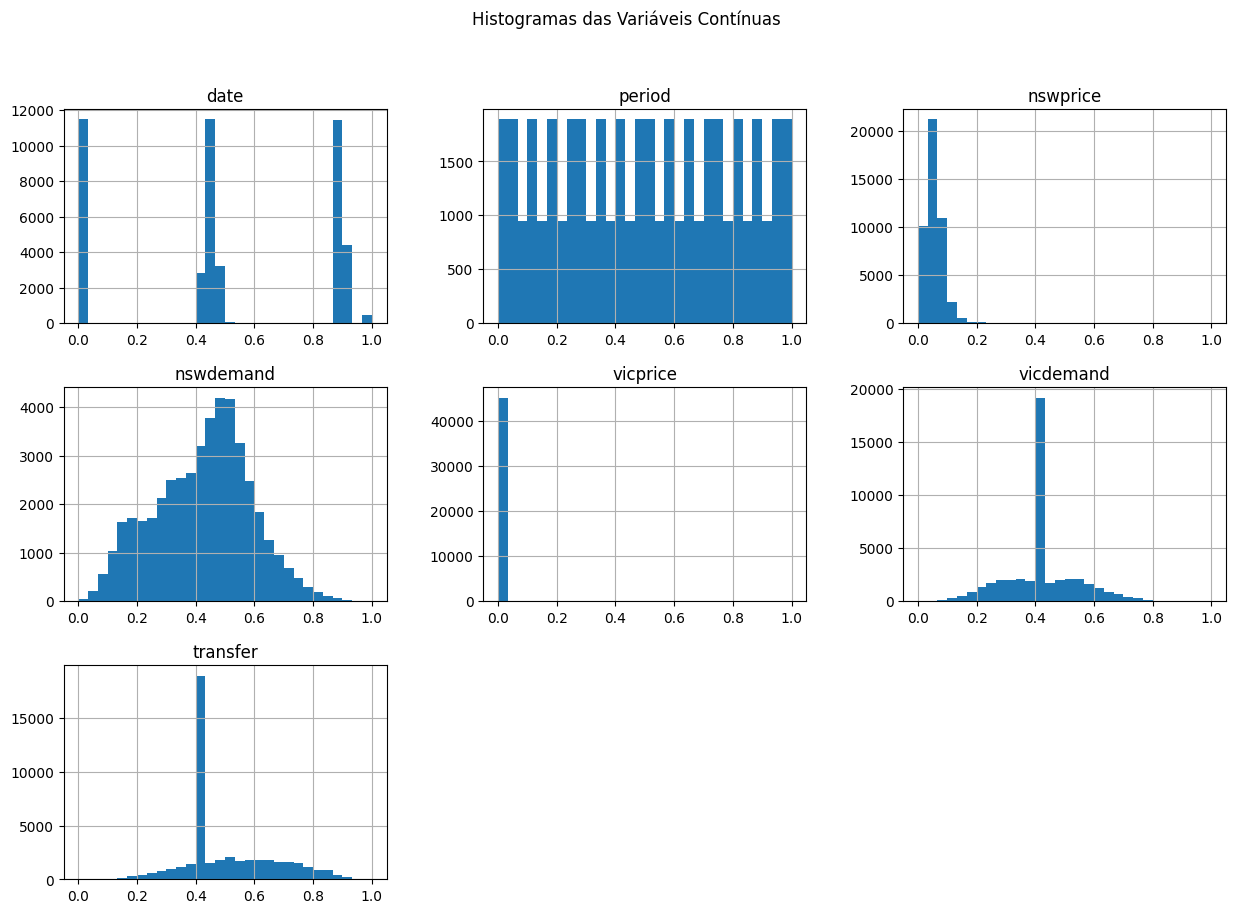

In [ ]:
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogramas das Variáveis Contínuas")
plt.show()

## Gráficos comparativos para distribuição dos dados entre as diferentes classes


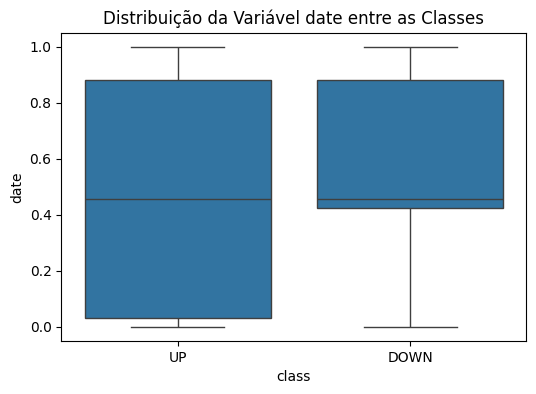

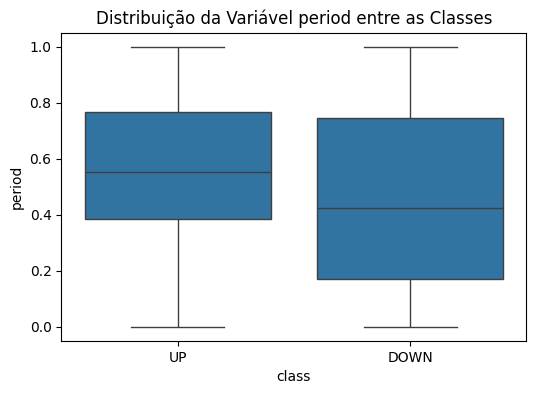

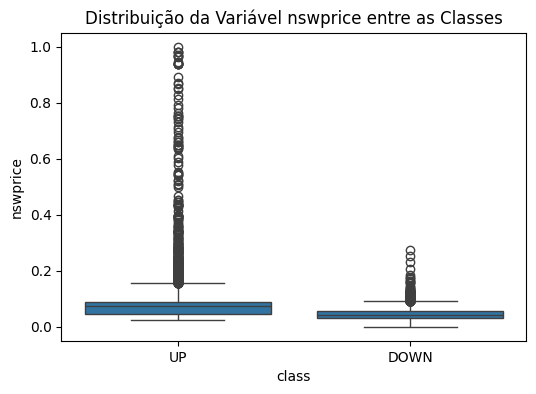

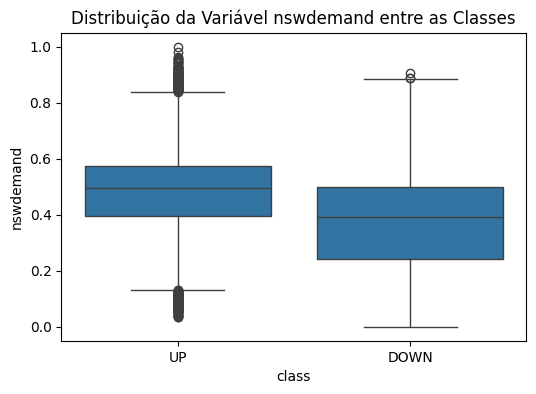

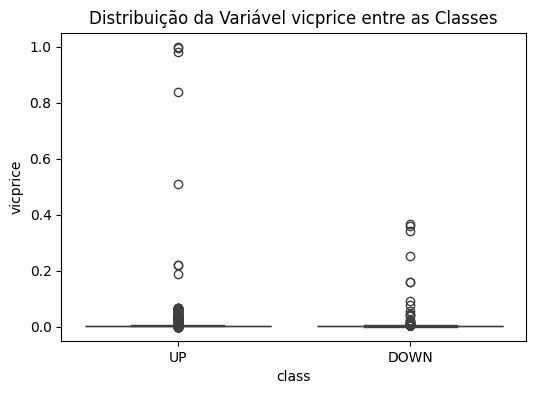

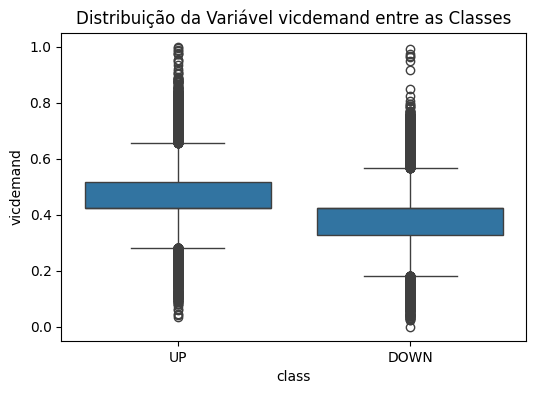

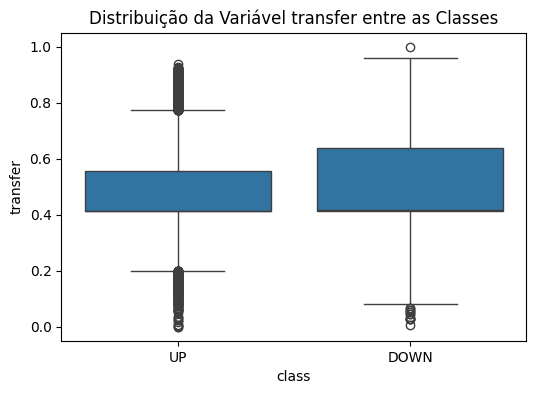

In [17]:
for col in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df['class'], y=df[col])
    plt.title(f"Distribuição da Variável {col} entre as Classes")
    plt.show()

# Matriz de Correlação

In [ ]:
corr = df.corr().iloc[::-1, ::-1]

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

fig.colorbar(cax)

for (i, j), val in np.ndenumerate(corr):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')


ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

plt.xticks(rotation=90)

plt.title("Matriz de Correlação", pad=20)
plt.show()

# Distribuição de demanda, valores e transfer ao longo dos dias

In [15]:
list_features = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']

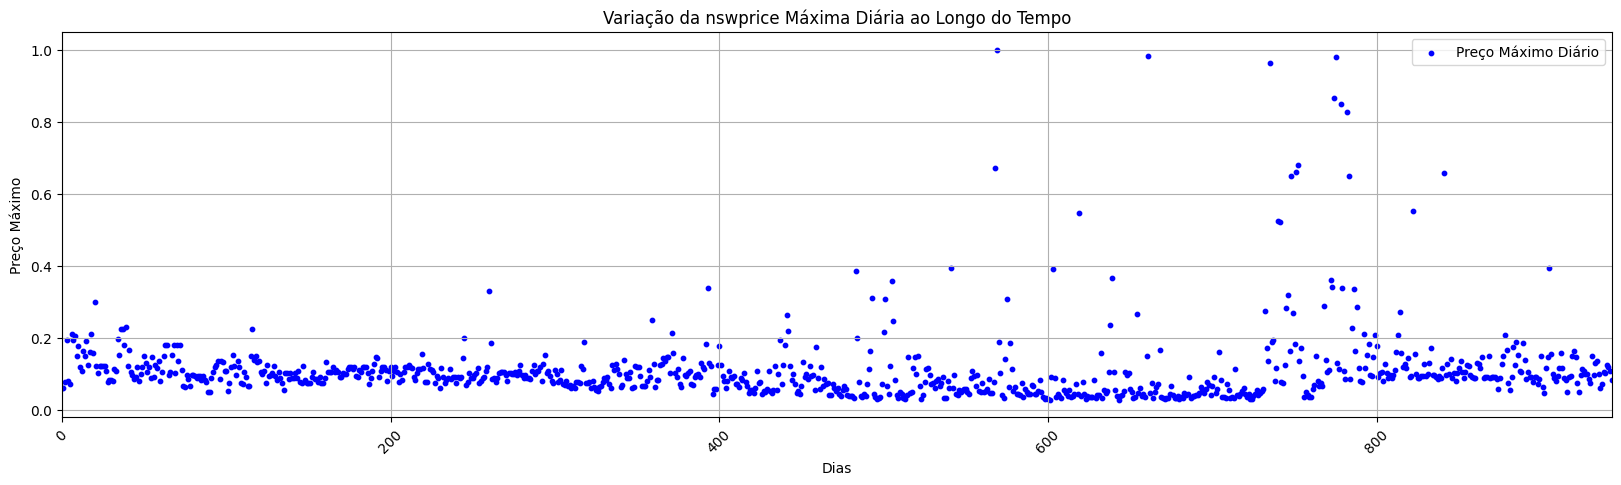

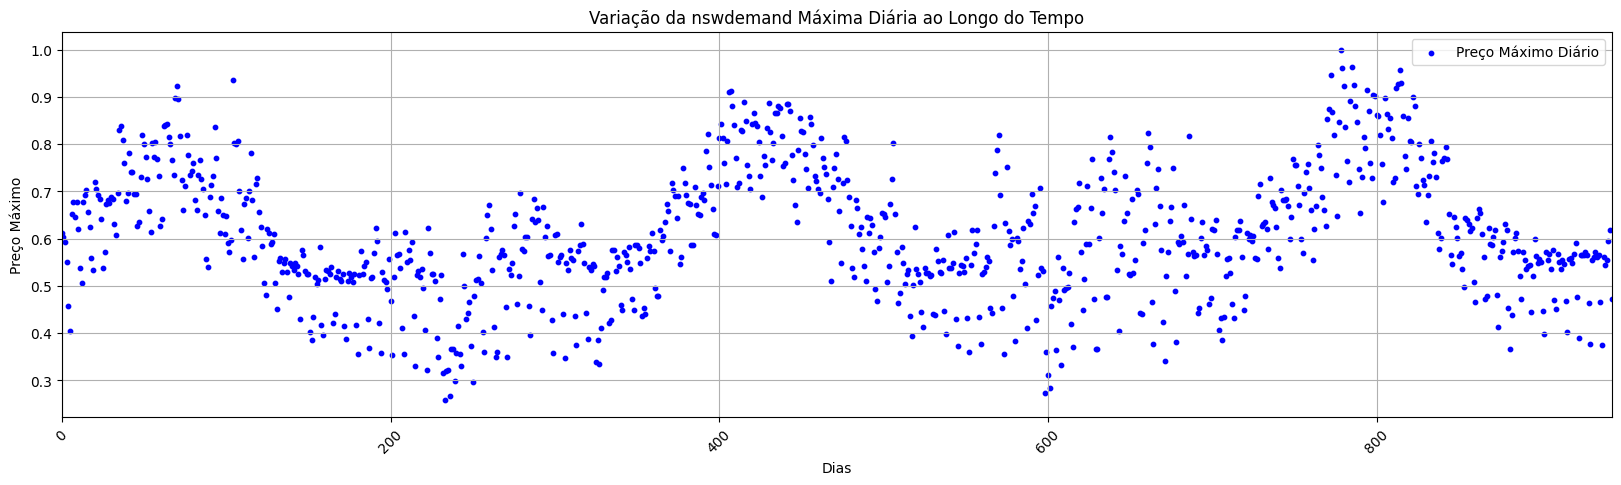

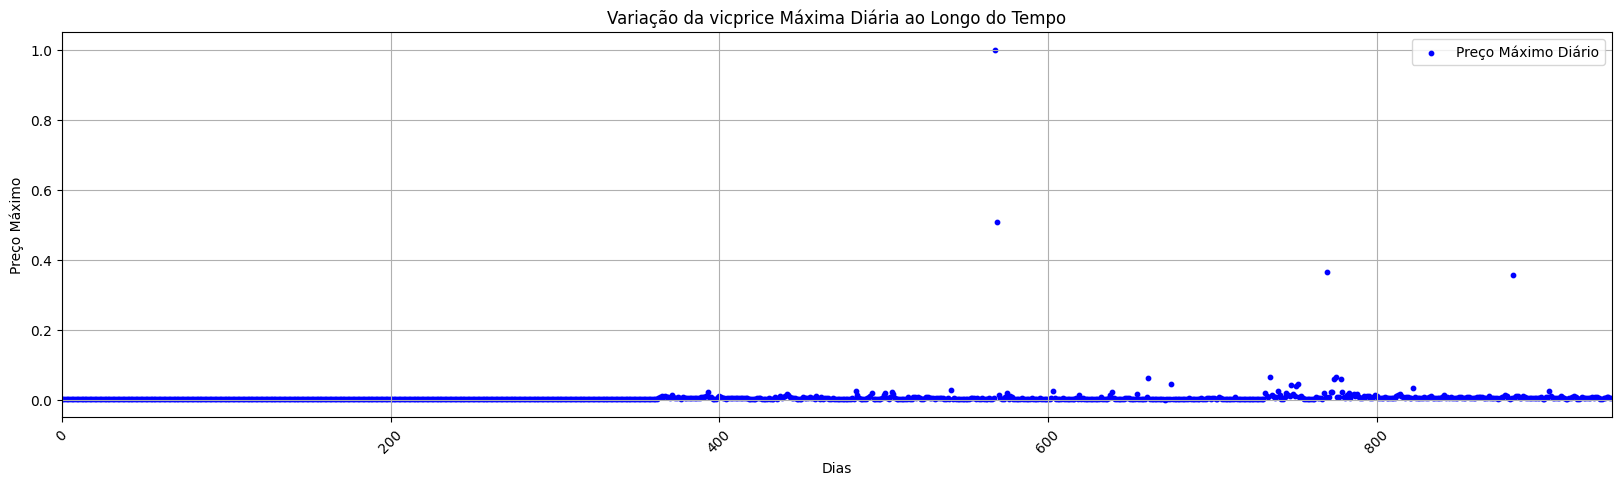

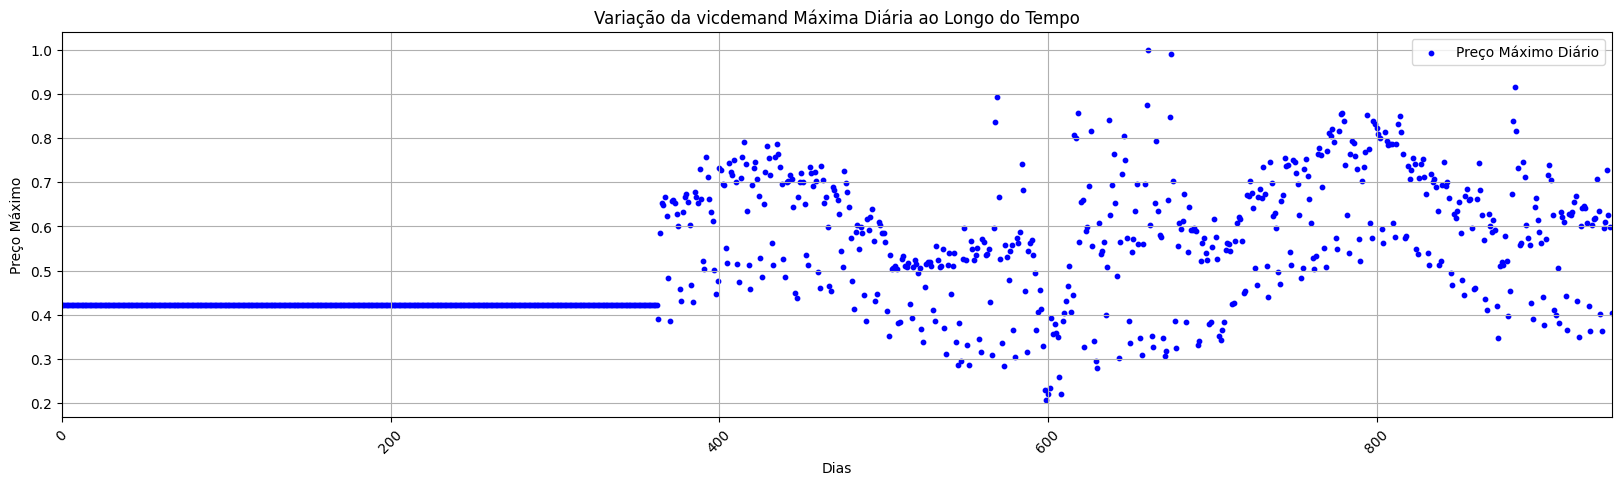

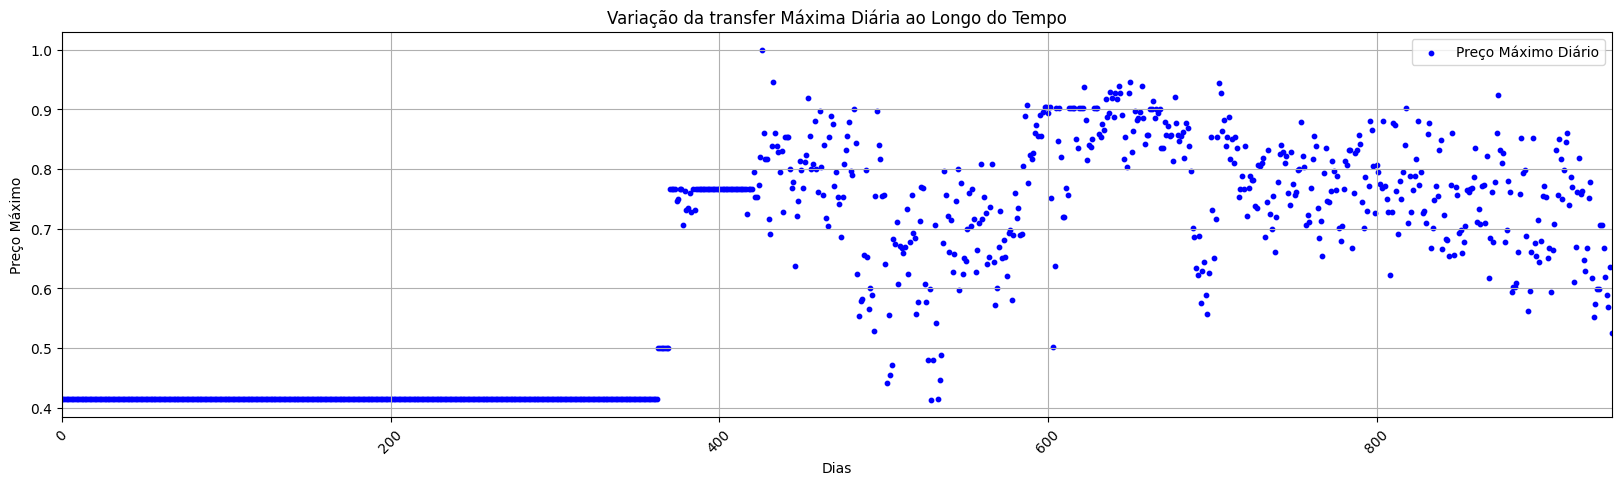

In [16]:
for variavel in list_features:
    precos_maximos_diarios = []
    medicoes_por_dia = 48
    
    for i in range(0, len(df), medicoes_por_dia):
        max_diario = df[variavel][i:i+medicoes_por_dia].max()
        precos_maximos_diarios.append(max_diario)


    dias = np.arange(len(precos_maximos_diarios))

    # Criar o gráfico de dispersão
    plt.figure(figsize=(20, 5))
    plt.scatter(dias, precos_maximos_diarios, color='b', label='Preço Máximo Diário', s=10)

    # Label do gráfico
    plt.xlabel('Dias')
    plt.ylabel('Preço Máximo')
    plt.title(f'Variação da {variavel} Máxima Diária ao Longo do Tempo')

    plt.xticks(rotation=45)
    plt.xlim(min(dias), max(dias))
    plt.legend()
    plt.grid()
    plt.show()

# Box Plot de demanda, valores e transfer ao longo pelos dias da semana

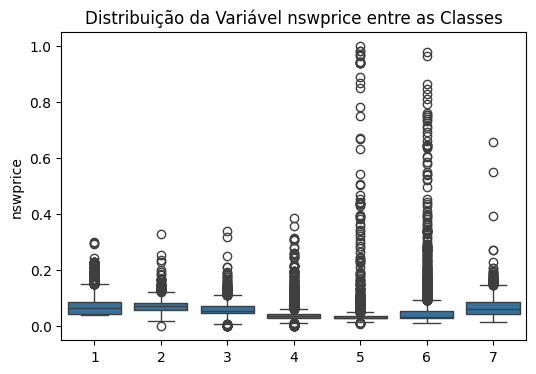

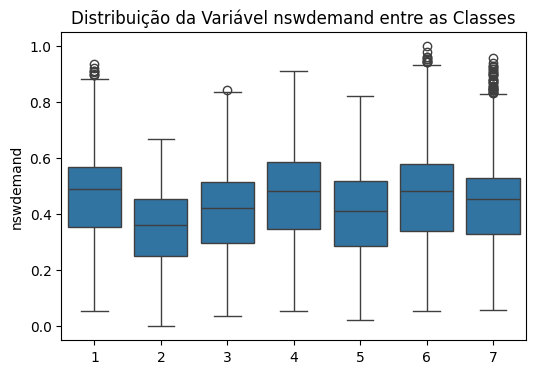

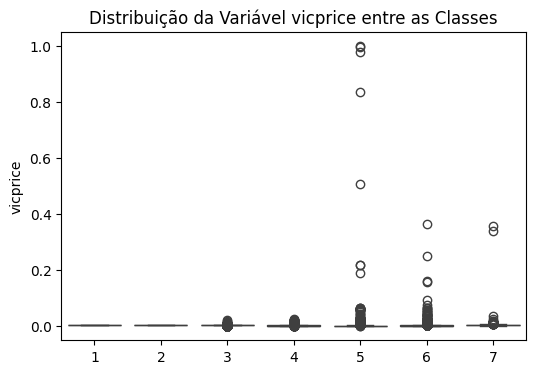

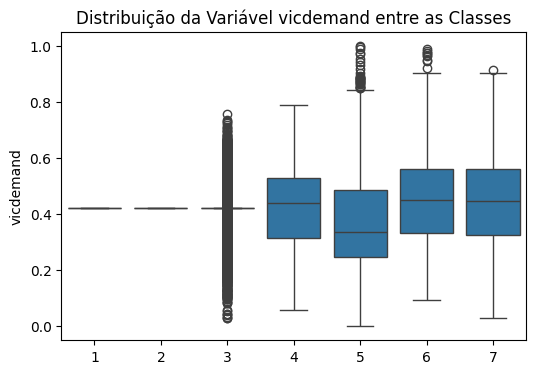

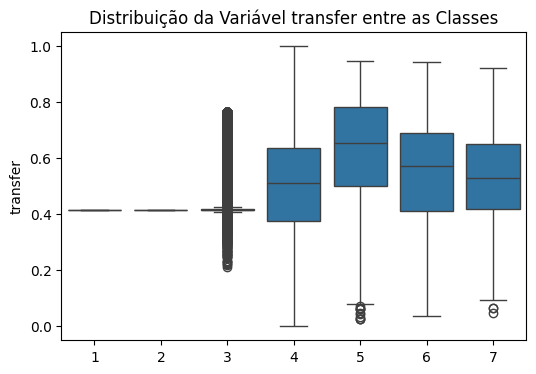

In [17]:
for col in list_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=sorted(df['day']), y=df[col])
    plt.title(f"Distribuição da Variável {col} entre as Classes")
    plt.show()

## Redução de Dimensionalidade

In [6]:
df['class'] = df['class'].replace({'UP': 1, 'DOWN': 0})

In [7]:
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0


In [8]:
Y_df = df['class']
X_df = df.drop(columns=['class'])

### t-SNE

In [9]:
tsne_2d = TSNE(n_components=2, random_state=42)

In [10]:
X_tsne = tsne_2d.fit_transform(X_df)

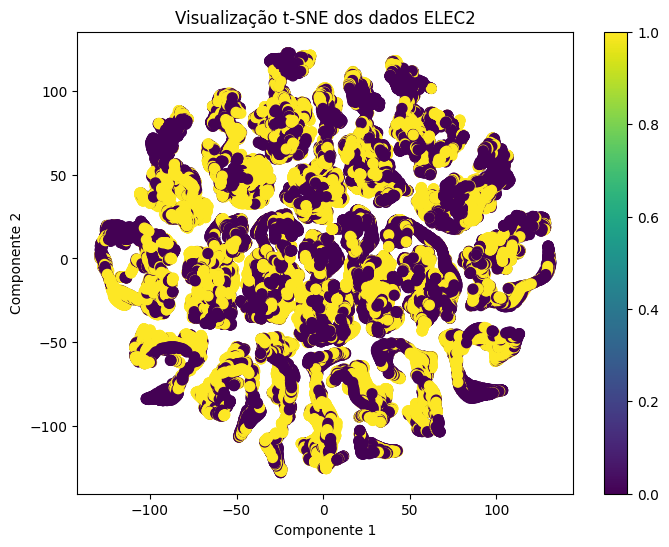

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_df, cmap='viridis', s=50)
plt.colorbar()
plt.title("Visualização t-SNE dos dados ELEC2")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

In [12]:
tsne_3d = TSNE(n_components=3, random_state=42)

In [13]:
X_tsne = tsne_3d.fit_transform(X_df)

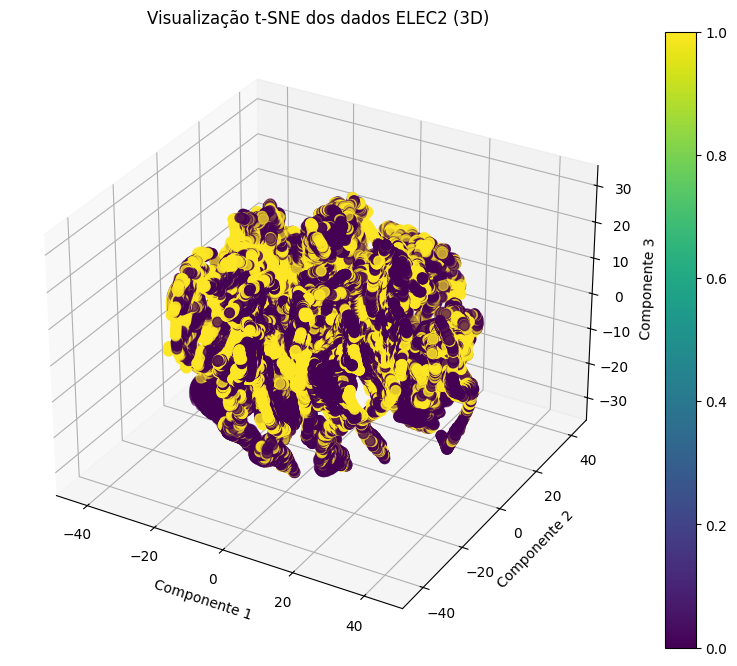

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=Y_df, cmap='viridis', s=50)
fig.colorbar(scatter)
ax.set_title("Visualização t-SNE dos dados ELEC2 (3D)")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
plt.show()

### UMAP

In [15]:
umap_2d = umap.UMAP(n_components=2, random_state=42)

In [16]:
X_umap = umap_2d.fit_transform(X_df)

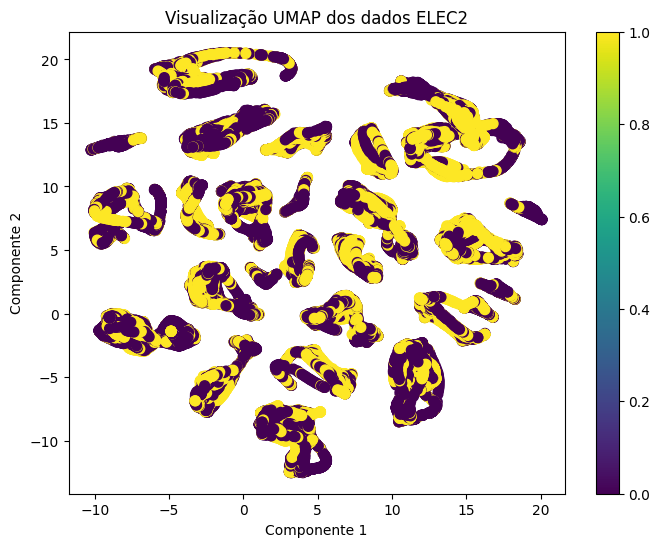

In [17]:
# Plotando os dados reduzidos com t-SNE
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=Y_df, cmap='viridis', s=50)
plt.colorbar()
plt.title("Visualização UMAP dos dados ELEC2")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

In [18]:
umap_3d = umap.UMAP(n_components=3, random_state=42)

In [19]:
X_umap = umap_3d.fit_transform(X_df)

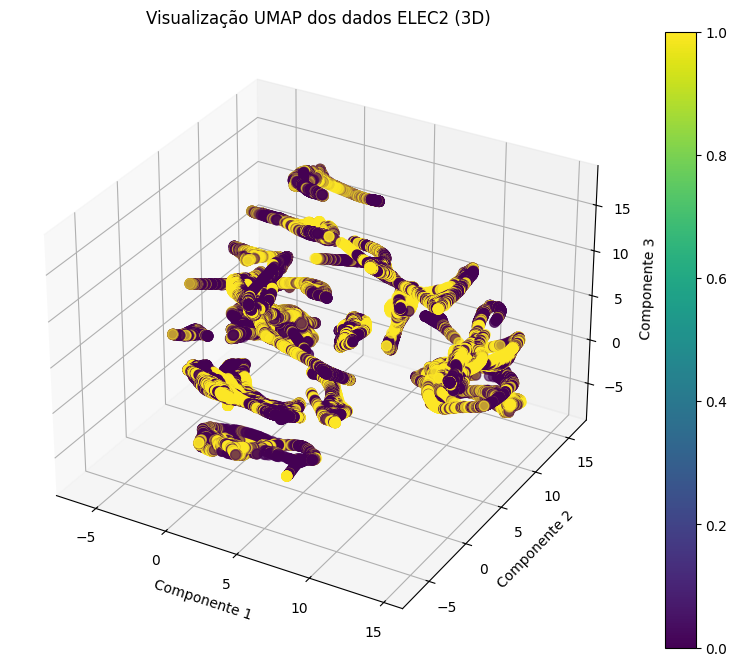

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=Y_df, cmap='viridis', s=50)
fig.colorbar(scatter)
ax.set_title("Visualização UMAP dos dados ELEC2 (3D)")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
plt.show()

### PCA

In [21]:
pca_2d = PCA(n_components=2)

In [22]:
X_pca = pca_2d.fit_transform(X_df)

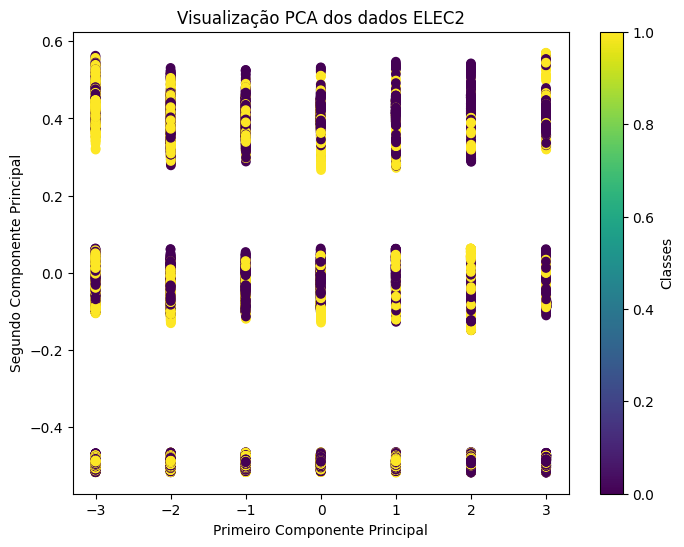

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_df, cmap='viridis')
plt.xlabel('Primeiro Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.title('Visualização PCA dos dados ELEC2')
plt.colorbar(label='Classes')
plt.show()

In [24]:
pca_3d = PCA(n_components=3)

In [25]:
X_pca = pca_3d.fit_transform(X_df)

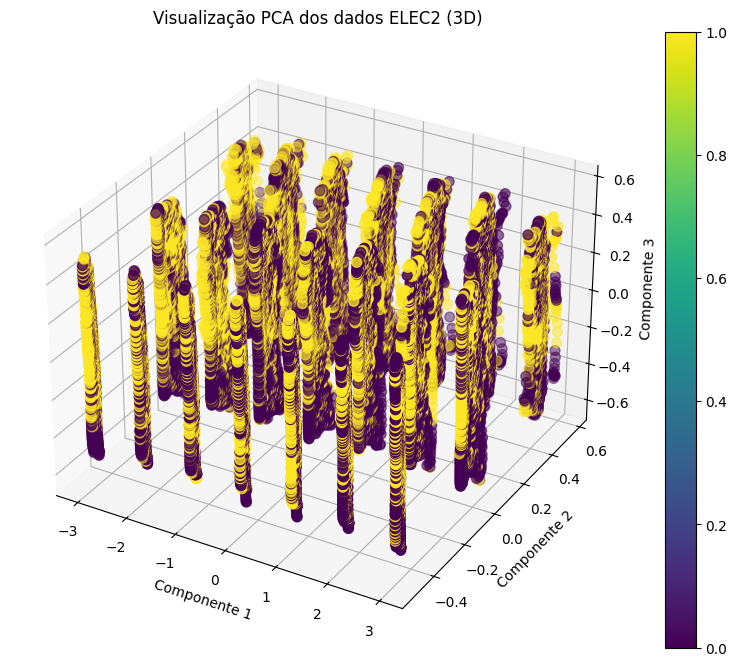

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=Y_df, cmap='viridis', s=50)
fig.colorbar(scatter)
ax.set_title("Visualização PCA dos dados ELEC2 (3D)")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
plt.show()